In [ ]:
pip install pyvi

In [ ]:
%tensorflow_version 2.x

# Import packages

In [ ]:
from __future__ import print_function
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import SGDClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from pyvi import ViTokenizer, ViPosTagger
import re
import string

import matplotlib.pyplot as plt
%matplotlib inline

# Preprocess data

In [ ]:
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER

def no_marks(s): # bỏ dấu của văn bản
    input = [ch for ch in VN_CHARS]
    output = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    output += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    r = re.compile("|".join(input))
    replace_dict = dict(zip(input, output))
    result = r.sub(lambda m: replace_dict[m.group(0)], s)
    return result

def normalize_text(text): #

    #Remove các ký tự kéo dài: vd: đẹpppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    #Chuyển thành chữ thường
    text = text.lower()

    #Chuẩn hóa tiếng Việt, xử lý emoji, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": " ", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' negative ', '😣': ' negative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' negative ', '😢': ' negative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' negative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' negative ', '😭': ' negative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' negative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' negative ', '😀': ' positive ', ':((': ' negative ', '😡': ' negative ', '😠': ' negative ',
        '😒': ' negative ', '🙂': ' positive ', '😏': ' negative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' negative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' negative ', '😓': ' negative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' negative ', ':3': ' positive ', '😫': ' negative ', '😥': ' negative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' negative ', '😑': ' negative ', '🔥': ' negative ', '🙏': ' negative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' negative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' negative ',  '💀': ' negative ',
        '😔': ' negative ', '😧': ' negative ', '😩': ' negative ', '😰': ' negative ', '😳': ' negative ',
        '😵': ' negative ', '😶': ' negative ', '🙁': ' negative ',
        #chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '4star': ' 5star ','4 sao': ' 5star ','4sao': ' 5star ',
        '3star': ' 3star ','3 sao': ' 3star ','3sao': ' 3star ', 'starstarstar':' 3star ',
        '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

    for x, y in replace_list.items():
        text = text.replace(x, y)

    #Chuyen punctuation thành space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    #Vitokenize text
    text = ViTokenizer.tokenize(text)

    #Remove những ký tự thừa thãi
    text = text.replace(u'"', u' ')
    text = text.replace(u'️', u'')
    text = text.replace('🏻','')
    return text

In [ ]:
def transform_to_dataset(X_dataset,y_dataset):
    X, y = [], []
    for document, topic in zip(list(X_dataset), list(y_dataset)):
        document = normalize_text(document)
        X.append(document.strip())
        y.append(topic)
        #augmentation bằng cách bỏ dấu tiếng Việt
        X.append(no_marks(document))
        y.append(topic)
    return X, y

In [ ]:
#load data
train_data = pd.DataFrame(pd.read_csv('data_reviews.csv'))
test_data = pd.DataFrame(pd.read_csv('test_reviews.csv'))

X_data, y_data = transform_to_dataset(train_data.comment, train_data.label)
X_test, y_test = transform_to_dataset(test_data.comment, test_data.label)

In [ ]:
#tạo train set và validation set từ tập train data
X_train, X_val, y_train, y_val = train_test_split(train_data.comment, train_data.label, test_size=0.3,random_state=2020)
X_train, y_train = transform_to_dataset(X_train,y_train)
X_val, y_val = transform_to_dataset(X_val, y_val)

# Fearture Extraction

## Count Vectorizer

In [ ]:
# #tạo count vectorizer từ training set
# count_vect = CountVectorizer()
# count_vect.fit(X_data) #fit trên tập train
# X_data_count = count_vect.transform(X_data)
# X_test_count = count_vect.transform(X_test)

## Tf-Idf

Word level

In [ ]:
# word level
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=10000)
tfidf_vect.fit(X_data)
X_data_tfidf =  tfidf_vect.transform(X_data)
X_test_tfidf =  tfidf_vect.transform(X_test) 

In [ ]:
X_data_tfidf.shape

(22520, 10000)

N-gram level

In [ ]:
# # ngram level
# tfidf_vect_ngram = TfidfVectorizer(analyzer='word', max_features=100000, ngram_range=(2, 3))
# tfidf_vect_ngram.fit(X_data)
# X_data_tfidf_ngram =  tfidf_vect_ngram.transform(X_data)
# X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

N-gram Char level

In [ ]:
# # ngram-char level
# tfidf_vect_ngram_char = TfidfVectorizer(analyzer='char', max_features=30000, ngram_range=(2, 3))
# tfidf_vect_ngram_char.fit(X_data)
# X_data_tfidf_ngram_char =  tfidf_vect_ngram_char.transform(X_data)
# X_test_tfidf_ngram_char =  tfidf_vect_ngram_char.transform(X_test)

## SVD for Tf_Idf

Word level

In [ ]:
from sklearn.decomposition import TruncatedSVD

#giảm chiều dữ liệu với SVD
svd = TruncatedSVD(n_components=300, random_state=2020)
svd.fit(X_data_tfidf)
X_data_tfidf_svd = svd.transform(X_data_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

# Machine Learning


In [ ]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10]}  

grid_svc = GridSearchCV(LinearSVC(), param_grid, verbose = 3) 
  
# fitting the model for grid search 
grid_svc.fit(X_data_tfidf_svd, y_data)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.891, total=   0.3s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............................... C=0.1, score=0.887, total=   0.3s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ............................... C=0.1, score=0.888, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.884, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.892, total=   0.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.891, total=   0.7s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.883, total=   0.7s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.886, total=   0.7s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.884, total=   0.7s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   29.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
# print best parameter after tuning 
print(grid_svc.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid_svc.best_estimator_) 

{'C': 0.1}
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [ ]:
# predict
grid_svc_predictions = grid_svc.predict(X_test_tfidf_svd)

# score  
score = metrics.accuracy_score(y_test, grid_svc_predictions)

# cross validation score
cross_score = cross_val_score(grid_svc, X_data_tfidf_svd, y_data, cv=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.890, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.875, total=   0.3s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.890, total=   0.3s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.888, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.892, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.889, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.875, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.891, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.888, total=   0.5s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   21.3s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.890, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.876, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.890, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.885, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.892, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.891, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.875, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.886, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.886, total=   0.5s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   21.8s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.890, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.883, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.880, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.888, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.893, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.891, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.881, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.878, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.887, total=   0.5s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   20.0s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.889, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.882, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.878, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.893, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.895, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.891, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.882, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.876, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.890, total=   0.5s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   20.1s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.888, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... C=0.1, score=0.885, total=   0.2s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.878, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.895, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.881, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.890, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.882, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.874, total=   0.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.893, total=   0.6s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   22.5s finished


In [ ]:
#report
# print classification report 
print('Classification report: \n', metrics.classification_report(y_test, grid_svc_predictions)) 
print('Accuracy score on test set:', score)
print("Cross validation 5 folds: %0.4f (+/- %0.4f)" % (cross_score.mean(), cross_score.std() * 2))

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      5578
           1       0.84      0.92      0.88      4076

    accuracy                           0.89      9654
   macro avg       0.89      0.90      0.89      9654
weighted avg       0.90      0.89      0.89      9654

Accuracy score on test set: 0.8914439610524135
Cross validation 5 folds: 0.8884 (+/- 0.0058)


In [ ]:
#error analysis - phân tích lỗi phân loại sai
for x, y1, y2 in zip(X_data, y_data, grid_svc_predictions):
    if y1 != y2:
        # print mẫu phân loại sai
        if y1!=1:
            print(x, y1, y2)

đóng_gói chắc_chắn hàng đẹp 0 1
dong_goi chac_chan hang dep 0 1
chất_lượng sản_phẩm tuyệt_vời cửa_hàng_phục_vụ rất tốt rất đáng tiền thời_gian giao hàng rất nhanh đóng_gói kỷ thêm chút nữa cửa_hàng nhé mình cắt bao_bì bi phạm vào làm rách bao bi chứa khô gà 0 1
chat_luong san_pham tuyet_voi cua_hang_phuc_vu rat tot rat dang tien thoi_gian giao hang rat nhanh dong_goi ky them chut nua cua_hang nhe minh cat bao_bi bi pham vao lam rach bao bi chua kho ga 0 1
cảm_ơn cửa_hàng giao hàng rất nhanh rất hài_lòng về sản_phẩm 0 1
cam_on cua_hang giao hang rat nhanh rat hai_long ve san_pham 0 1
cua_hang_phuc_vu rat tot rat ung 0 1
chất_liệu và kiểu_dáng thì được nhưng quần hơi ngắn 0 1
chat_lieu va kieu_dang thi duoc nhung quan hoi ngan 0 1
bánh ngon bé tập bốc nhón tốt 0 1
banh ngon be tap boc nhon tot 0 1
hài_lòng về sản_phẩm và cách phục_vụ giao hàng nhanh 0 1
hai_long ve san_pham va cach phuc_vu giao hang nhanh 0 1
k có gì để chê từ gói hàng đến chất_lượng đều ok mua nhiều rồi chưa bg thất_vọn

# Deep Learning


## Define functions

In [ ]:
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Reshape, Concatenate,\
      GRU, Bidirectional, Conv1D, Flatten, TimeDistributed, MaxPool1D, BatchNormalization, Add, concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
def train_model(classifier, X_data, y_data, X_test, y_test, n_epochs=3):       
    
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
    
    history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=512)
        
    val_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(X_test)
    val_predictions = val_predictions.argmax(axis=-1)
    test_predictions = test_predictions.argmax(axis=-1)
        
    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))
    return history

In [ ]:
 def plot_acc_loss(history):
    plt.subplot(1, 2, 1)

    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)

    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.optimizers import SGD 
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalMaxPool1D, MaxPool1D
from keras import Sequential

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
len(tokenizer.word_index)

# integer encode the documents
vocab_size = 10000
#max_length = 300 # len of a row of truncated SVD data

#Dont use below because GPU out of memory, use SVD data instead
max_length = 2716

X_data_encoded = [one_hot(d, vocab_size) for d in X_data]
X_test_encoded = [one_hot(d, vocab_size) for d in X_test]

X_data_padded = pad_sequences(X_data_encoded, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

## Feed-Forward Neural Networks

### FNN with TFIDF

In [ ]:
def create_dnn_model_tfidf():
    model = Sequential()
    model.add(Input(shape=300,))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

DNN_tfidf = create_dnn_model_tfidf()
DNN_tfidf_history = train_model(classifier=DNN_tfidf, X_data=X_data_tfidf_svd, y_data=np.asarray(y_data), X_test=X_test_tfidf_svd, y_test=np.asarray(y_test))

Epoch 1/3
40/40 [==============================] - 0s 6ms/step - loss: 1.6481 - accuracy: 0.6154 - val_loss: 0.7543 - val_accuracy: 0.6199
Epoch 2/3
40/40 [==============================] - 0s 3ms/step - loss: 0.5407 - accuracy: 0.7669 - val_loss: 0.3739 - val_accuracy: 0.8819
Epoch 3/3
40/40 [==============================] - 0s 3ms/step - loss: 0.3193 - accuracy: 0.8735 - val_loss: 0.2771 - val_accuracy: 0.8881
Validation accuracy:  0.8880994671403197
Test accuracy:  0.8858504246944272


In [ ]:
DNN_tfidf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               38528     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 56,330
Trainable params: 56,330
Non-trainable params: 0
_________________________________________________________________


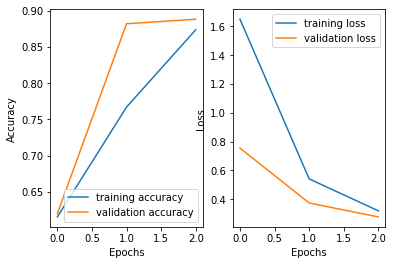

In [ ]:
plot_acc_loss(DNN_tfidf_history)

### FNN with Keras Embedding

In [ ]:
def create_dnn_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 64, input_length=max_length))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

DNN = create_dnn_model()

In [ ]:
 DNN_history = train_model(classifier=DNN, X_data=X_data_padded, y_data=np.asarray(y_data), X_test=X_test_padded, y_test=np.asarray(y_test))

Epoch 1/3
40/40 [==============================] - 14s 362ms/step - loss: 1.2380 - accuracy: 0.5510 - val_loss: 0.6701 - val_accuracy: 0.5622
Epoch 2/3
40/40 [==============================] - 14s 359ms/step - loss: 0.5604 - accuracy: 0.7164 - val_loss: 0.4188 - val_accuracy: 0.8206
Epoch 3/3
40/40 [==============================] - 14s 360ms/step - loss: 0.3398 - accuracy: 0.8579 - val_loss: 0.3213 - val_accuracy: 0.8699
Validation accuracy:  0.8698934280639432
Test accuracy:  0.8619225191630412


In [ ]:
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2716, 64)          640000    
_________________________________________________________________
dense_3 (Dense)              (None, 2716, 128)         8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2716, 128)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 2716, 128)         16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 2716, 128)         0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

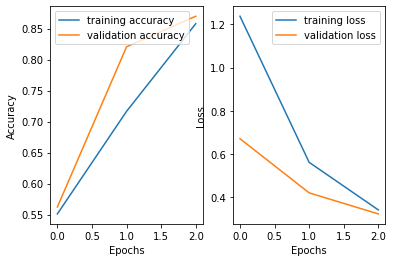

In [ ]:
plot_acc_loss(DNN_history)

## LSTM

In [ ]:
%tensorflow_version 2.x

In [ ]:
def create_lstm_model():
    model = Sequential()

    model.add(Embedding(vocab_size, 64, input_length=max_length))

    model.add(LSTM(128, return_sequences=True ))
    model.add(GlobalMaxPool1D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer= Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

LSTM = create_lstm_model()
LSTM_history = train_model(LSTM, X_data= X_data_padded, y_data=np.asarray(y_data), X_test=X_test_padded, y_test=np.asarray(y_test), n_epochs=3)

Epoch 1/3
40/40 [==============================] - 24s 604ms/step - loss: 0.9607 - accuracy: 0.5346 - val_loss: 0.6800 - val_accuracy: 0.5622
Epoch 2/3
40/40 [==============================] - 24s 597ms/step - loss: 0.5255 - accuracy: 0.7078 - val_loss: 0.3203 - val_accuracy: 0.8721
Epoch 3/3
40/40 [==============================] - 25s 628ms/step - loss: 0.2819 - accuracy: 0.8900 - val_loss: 0.2648 - val_accuracy: 0.8952
Validation accuracy:  0.8952042628774423
Test accuracy:  0.891029625025896


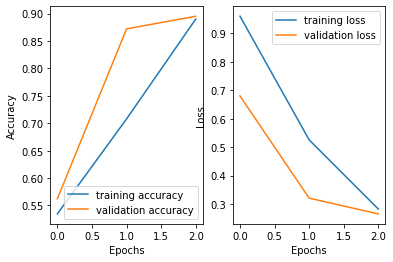

In [ ]:
plot_acc_loss(LSTM_history)

In [ ]:
LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2716, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 2716, 128)         98816     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

## LSTM-CNN

In [ ]:
def create_rcnn_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 64, input_length=max_length))

    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Conv1D(100, 3, activation="relu"))
    model.add(MaxPool1D(5))
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer= Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

LSTM_CNN = create_rcnn_model()

In [ ]:
LSTM_CNN_history = train_model(classifier=LSTM_CNN, X_data=X_data_padded, y_data=np.asarray(y_data), X_test=X_test_padded, y_test=np.asarray(y_test))

Epoch 1/3
40/40 [==============================] - 175s 4s/step - loss: 1.1651 - accuracy: 0.5373 - val_loss: 2.1804 - val_accuracy: 0.5622
Epoch 2/3
40/40 [==============================] - 174s 4s/step - loss: 1.9607 - accuracy: 0.5757 - val_loss: 1.6869 - val_accuracy: 0.5622
Epoch 3/3
40/40 [==============================] - 176s 4s/step - loss: 1.4077 - accuracy: 0.5760 - val_loss: 1.1374 - val_accuracy: 0.5622
Validation accuracy:  0.5621669626998224
Test accuracy:  0.5777915889786617


In [ ]:
LSTM_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2716, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 2716, 128)         98816     
_________________________________________________________________
conv1d (Conv1D)              (None, 2714, 100)         38500     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 542, 100)          0         
_________________________________________________________________
flatten (Flatten)            (None, 54200)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6937728   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

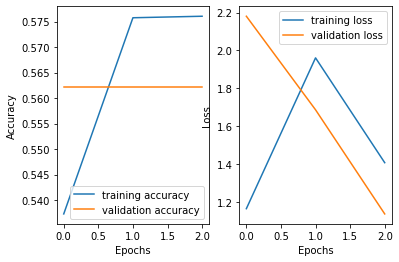

In [ ]:
plot_acc_loss(LSTM_CNN_history)

## TextCNN

In [ ]:
def TextCNN():
    input = Input(shape=(300,))
    embedder = Embedding(20000, 300, trainable=True)
    embed = embedder(input)

    cnn1 = Conv1D(256, 3, padding='same', strides=1, activation='relu')(embed)
    cnn1 = MaxPool1D(pool_size=48)(cnn1)
    cnn2 = Conv1D(256, 4, padding='same', strides=1, activation='relu')(embed)
    cnn2 = MaxPool1D(pool_size=47)(cnn2)
    cnn3 = Conv1D(256, 5, padding='same', strides=1, activation='relu')(embed)
    cnn3 = MaxPool1D(pool_size=46)(cnn3)
    # Combine the output vectors of the three models
    cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.2)(flat)
    output = Dense(3, activation='softmax')(drop)
    model = Model(inputs=input, outputs=output)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

TextCNN = TextCNN()

In [ ]:
TextCNN_history = train_model(classifier=TextCNN, X_data=X_data_tfidf_svd, y_data=np.asarray(y_data), X_test=X_test_tfidf_svd, y_test=np.asarray(y_test), n_epochs=2)

Epoch 1/2
40/40 [==============================] - 17s 420ms/step - loss: 0.6985 - accuracy: 0.4112 - val_loss: 0.7089 - val_accuracy: 0.4378
Epoch 2/2
40/40 [==============================] - 16s 399ms/step - loss: 0.6979 - accuracy: 0.3199 - val_loss: 0.7089 - val_accuracy: 0.4378
Validation accuracy:  0.43783303730017764
Test accuracy:  0.4222084110213383


In [ ]:
TextCNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 300, 256)     230656      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 300, 256)     307456      embedding_1[0][0]                
_______________________________________________________________________________________

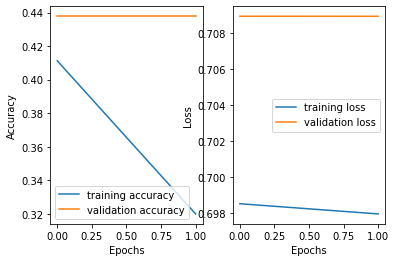

In [ ]:
plot_acc_loss(TextCNN_history)